In [1]:
import pandas as pd
import cv2
import numpy as np

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms
import torch.utils.data as data
from torch.utils.data.sampler import SubsetRandomSampler

import pickle
from tqdm.notebook import tqdm


In [3]:
def preprocess_data(directory:str, batch_size:int, test_size:int, rand_num:int, worker:int):
    '''
        directory: the directory of processed directory with class folders inside
        batch_size: size of batch for training
        test_size: percent of dataset used for test
        rand_num: put random number for reproducibility
        worker: number of worker in computation
        
        return train and test data ready for training
    '''
    #pipeline to resize images, crop, convert to tensor, and normalize
    trans = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])])
    
    dataset = torchvision.datasets.ImageFolder(root=directory, transform=trans) #read image in folder to data with labels
    
    train_len = len(dataset) #get length of whole data
    ind = list(range(train_len)) #indices of whole data
    spl = int(np.floor(test_size * train_len)) #index of test data
    
    #reproducibility and shuffle step
    np.random.seed(rand_num) 
    np.random.shuffle(ind)
    
    #sampling preparation steps
    train_id, test_id = ind[spl:], ind[:spl]
    tr_sampl = SubsetRandomSampler(train_id)
    te_sampl = SubsetRandomSampler(test_id)

    #use data loader to get train and test set ready for training
    trainloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=tr_sampl,num_workers=worker)
    testloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=te_sampl,num_workers=worker)
    return (trainloader, testloader)

In [4]:
dire = "./Data/Processed" # directory of dataset
# loading data loader
trainloader, testloader = preprocess_data(directory=dire, batch_size=16, test_size=0.3, rand_num=40, worker=4)
# getting device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
vgg16 = torchvision.models.vgg16(pretrained=True)
modules = list(vgg16.children())[:-1]
print(modules)
vgg16_model = nn.Sequential(*modules)

[Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_s

In [6]:
resnet50 = torchvision.models.resnet50(pretrained=True)
modules = list(resnet50.children())[:-1]
print(modules)
resnet50_model = nn.Sequential(*modules)

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False), BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), ReLU(inplace=True), MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False), Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=Tr

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:[1/10], training loss: 2.1596
Epoch:[2/10], training loss: 1.3557
Epoch:[3/10], training loss: 1.2582
Epoch:[4/10], training loss: 1.1250
Epoch:[5/10], training loss: 1.0117
Epoch:[6/10], training loss: 1.0349
Epoch:[7/10], training loss: 0.8174
Epoch:[8/10], training loss: 0.7963
Epoch:[9/10], training loss: 0.6547
Epoch:[10/10], training loss: 0.5731


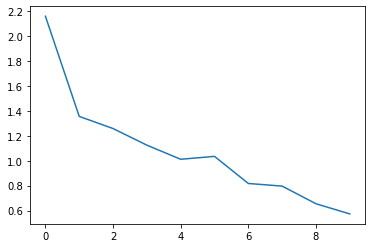

In [7]:
#net = resnet50
from ipywidgets import IntProgress
net = vgg16
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
net = net.to(device)
losses = []
epochs = 10
for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times
# YOUR CODE HERE
    Loss = 0.0
    count = 0
    for iter, data in enumerate(trainloader, 0):
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        predicted = net(images)
        _, pre1 = torch.max(predicted,dim=1)

        optimizer.zero_grad()
        loss = criterion(predicted, labels)
        loss.backward()
        optimizer.step()

        Loss += loss.item() #accumulate the loss
        count += 1

    avg_loss = Loss/count
    losses.append(avg_loss) #append the average loss for each batch
    print('Epoch:[{}/{}], training loss: {:.4f}'.format(epoch+1, epochs, avg_loss))

plt.plot(losses)

In [8]:
correct = 0
total = 0

# YOUR CODE HERE
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        y_hat = net(images)
        max_val, max_i = torch.max(y_hat.data, 1)
        print(y_hat)
        total += labels.size(0)
        correct += (max_i == labels).sum().item()
        
print(f'Accuracy of the network on the 10000 validation x: {100 * correct // total} %')

tensor([[12.0579,  8.3368, 18.8805,  ..., -0.6232, -1.0158,  1.3395],
        [12.5573, 12.8453,  9.3498,  ...,  0.2685, -0.5206, -0.5723],
        [12.1452, 11.0017, 13.9310,  ...,  1.7481, -0.3436, -0.3170],
        ...,
        [12.0121, 13.5391, 10.9859,  ..., -1.0550, -1.1673,  0.6325],
        [10.7536, 10.1124, 10.3241,  ...,  0.0449, -0.6461,  0.6054],
        [13.1822,  9.5288, 18.1492,  ..., -0.4896,  0.1392,  1.4853]])
tensor([[ 9.5027e+00,  8.4043e+00,  8.6727e+00,  ..., -4.7133e-01,
         -1.8746e-01,  1.3598e-01],
        [ 8.8426e+00,  7.1278e+00,  1.3988e+01,  ..., -5.3596e-01,
         -1.6156e-01,  1.1526e+00],
        [ 1.2928e+01,  1.2434e+01,  9.7942e+00,  ..., -3.0590e-01,
         -3.3673e-01,  6.4226e-01],
        ...,
        [ 1.2059e+01,  8.2988e+00,  1.5801e+01,  ...,  3.7673e-01,
         -3.0855e-01,  2.1624e-01],
        [ 1.0676e+01,  8.6747e+00,  1.5129e+01,  ..., -2.3119e-01,
         -1.0577e+00,  1.1558e+00],
        [ 1.0197e+01,  7.2620e+00,  1.